# E11 : 폐렴 진단기 성능개선
#### setup

In [2]:
# 패키지 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 변수 설정
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


####  데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터 개수 확인
print('train 파일 수 :',len(train_filenames))
print('test 파일 수 :', len(test_filenames))
print('validation 파일 수 :',len(val_filenames))

train 파일 수 : 5216
test 파일 수 : 624
validation 파일 수 : 16


validation 수가 16으로 턱없이 부족하므로 5216개인 상대적으로 많은 train 데이터로부터 파일을 가져와서 validation 파일 수를 늘려보자 

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('새로운 train 파일 수 :',len(train_filenames))
print('새로운 validation 파일 수 :',len(val_filenames))

새로운 train 파일 수 : 4185
새로운 validation 파일 수 : 1047


우선, train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 살펴보자

In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있다
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0614-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


#### tf.data 이용
train 데이터의 경우 클래스별 balance가 좋을 수록 training을 잘한다고 한다. 그러나 data수를 보면 정상 이미지수는 1072, 폐렴 이미지수는 3113으로 정상보다 폐렴 이미지 수가 3배 더 많이 있다. 그에 반해, test와 val 데이터셋을 평가가 목적이므로 클래스별 imbalance함이 문제가 되지 않는다.

In [7]:
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해준다
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 각종 함수들 생성
- get_label 함수: 현재 이미지에는 라벨 데이터가 따로 없기 때문에 라벨 데이터를 만들어 주는 함수를 만들어 보자.   
어떻게? 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용한다.   
   
   
- decode_img 함수, process_path 함수: 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.   
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자   
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경하고   
get_label을 이용해서 라벨 값을 가져온다

In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#### train, validation, test 데이터셋

In [9]:
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해준다
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
# test 데이터셋
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print('test 이미지 개수:',TEST_IMAGE_COUNT)

Image shape:  (180, 180, 3)
Label:  False
test 이미지 개수: 624


In [10]:
# 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환시켜주는 함수
def prepare_for_training(ds, shuffle_buffer_size=1000): 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # shuffle()을 사용하며 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    
    ds = ds.repeat()
    # repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 된다.
    # 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다.
    # 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 되는데 repeat()를 사용하면 자동으로 데이터를 맞춰준다.
    
    ds = ds.batch(BATCH_SIZE)
    # batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    # prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 
    # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출한다.
- 추출된 배치를 image와 label 데이터 셋으로 나눈 후 show_batch() 함수를 이용해서 결과 사진을 본다.

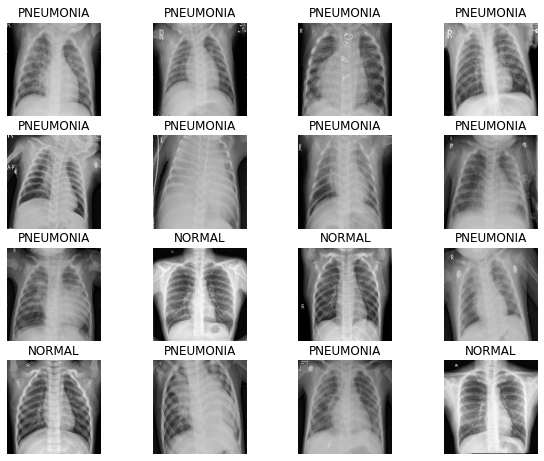

In [11]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링
- CNN, Convolutional Neural Network란?
  - 1) Convolution block을 만듦
  - 2) conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
  - 3) Max Pooling

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 전형적인 CNN 모델과는 다른 모델
- Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있다.
- variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### data imbalance 처리 > 해결방안: Weight balancing
- 데이터 imbalance 문제
- 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많다. 
- 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 것이다. 

- 해결하는 방법: Weight balancing
- Weight balancing : training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법- - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원
- 딥러닝에서 클래스 불균형을 다루는 방법

In [20]:
# Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 # Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


####  모델 훈련

In [21]:
with tf.device('/GPU:0'): # GPU 선택
    model = build_model() # build_model()을 model에 선언합니다.

# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 두 개이기 때문에 "binary_cross entropy" loss를 사용
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 154ms/step - loss: 0.4924 - accuracy: 0.7400 - precision: 0.9372 - recall: 0.7010 - val_loss: 0.6498 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 37s 142ms/step - loss: 0.3528 - accuracy: 0.8621 - precision: 0.9549 - recall: 0.8551 - val_loss: 1.1618 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 38s 144ms/step - loss: 0.2115 - accuracy: 0.9196 - precision: 0.9798 - recall: 0.9110 - val_loss: 0.2620 - val_accuracy: 0.9048 - val_precision: 0.9854 - val_recall: 0.8835
Epoch 4/25
261/261 [==============================] - 37s 142ms/step - loss: 0.2135 - accuracy: 0.9229 - precision: 0.9765 - recall: 0.9196 - val_loss: 2.0467 - val_accuracy: 0.4731 - val_precision: 1.0000 - val_recall: 0.2818
Epoch 5/25
261/261 [==============================] - 37s 142ms/step - loss: 0.1959 - accura

#### 결과 확인
그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다.

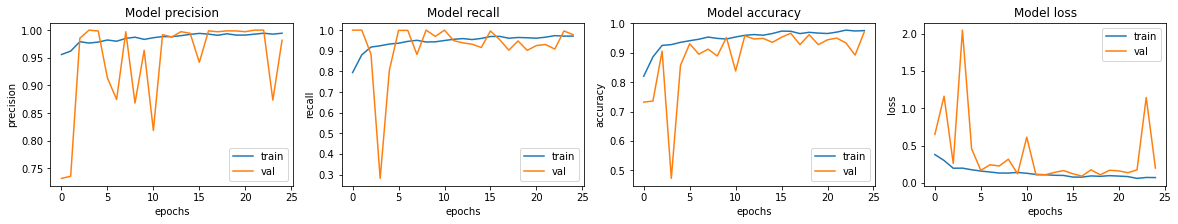

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력한다.

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 86ms/step - loss: 1.6429 - accuracy: 0.7740 - precision: 0.7371 - recall: 0.9923
Loss: 1.6428964138031006,
Accuracy: 0.7740384340286255,
Precision: 0.7371428608894348,
Recall: 0.9923076629638672


# 변경
- batch size
- epoch

In [30]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [52]:
BATCH_SIZE = 40 # 30 > 25 > 40
EPOCHS = 20 # 40 > 35

In [53]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
104/104 [==============================] - 25s 183ms/step - loss: 0.0075 - accuracy: 0.9982 - precision: 1.0000 - recall: 0.9976 - val_loss: 0.0734 - val_accuracy: 0.9808 - val_precision: 1.0000 - val_recall: 0.9739
Epoch 2/20
104/104 [==============================] - 18s 178ms/step - loss: 0.0405 - accuracy: 0.9892 - precision: 0.9959 - recall: 0.9893 - val_loss: 0.3636 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.8284
Epoch 3/20
104/104 [==============================] - 18s 176ms/step - loss: 0.0291 - accuracy: 0.9904 - precision: 0.9984 - recall: 0.9887 - val_loss: 0.0872 - val_accuracy: 0.9688 - val_precision: 0.9935 - val_recall: 0.9654
Epoch 4/20
104/104 [==============================] - 18s 177ms/step - loss: 0.0188 - accuracy: 0.9946 - precision: 0.9992 - recall: 0.9935 - val_loss: 0.0831 - val_accuracy: 0.9712 - val_precision: 1.0000 - val_recall: 0.9612
Epoch 5/20
104/104 [==============================] - 18s 173ms/step - loss: 0.0061 - accura

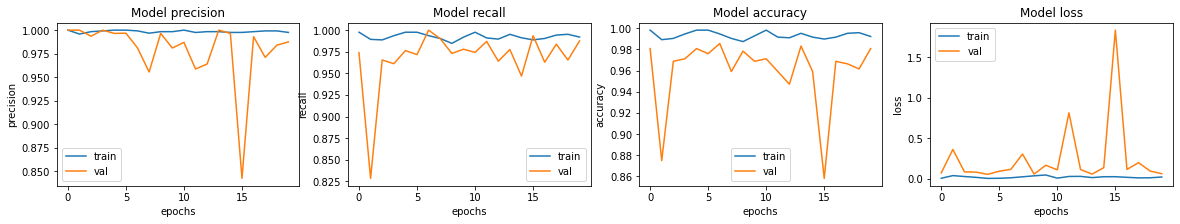

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [55]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 86ms/step - loss: 1.9059 - accuracy: 0.7740 - precision: 0.7362 - recall: 0.9949
Loss: 1.905869722366333,
Accuracy: 0.7740384340286255,
Precision: 0.7362428903579712,
Recall: 0.9948717951774597


#### 회고
- 그래프를 보면 중간중간에 튀는 부분이 많아서 이게 맞나 싶다. 뭔가 처음에는 삐죽빼죽하더라도 점점 안정화되는 느낌이 있어야하는데 계속 삐죽빼죽해서 validation이 제대로 되고있나 싶다. 원인은 validation 데이터가 너무 적어서인 것 같다.
- 모델을 바꿔보는 것이 좋겠지만 그냥 단순하게 epoch 수와 batch size를 변경해보는 데에 그쳤다. 
 - epoch: 40 > 35 > 20
 - batch size: 30 > 25 > 40
 - epoch를 바꾼 기준은 그래프를 보구 overfitting이 발생했다고 보인 지점 전으로 epoch를 잡아주려다보니 계속 줄여주는 방향으로 수정했다.
 - batch size를 줄인다면 덜 삐뚤빼뚤해지는 효과가 있으나 training 속도가 느려진다. 속도를 높여주기 위해 batch size를 늘려주었으나 삐뚤빼뚤함이 증가해 정확도를 높여주는 데에는 방해가 된 것 같다. 그래서 85퍼를 달성하지 못한 것 같다.